In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from utils import *
from Dataset.datasets import *
from Dataset.aggregation import *
from Dataset.metrics import *
from Optimization.clustering import *
from Optimization.portfolio_opt import *
from Evaluation.evaluate import *
from Evaluation.Plot_results import *
warnings.filterwarnings('ignore')

### Dates for training and evaluation

In [2]:
start_date_train = '2006-06-01'
end_date_train = '2016-01-01'

start_date_validation = '2016-01-01'
end_date_validation = '2024-01-23'

[*********************100%%**********************]  503 of 503 completed


## Dataset preparation

In [ ]:
df = download_stock_data(market_country ='US', 
                         start_date = '2006-01-01',)

In [ ]:
df.head()

## Prepare the data

In [3]:
stock_measures = StockMeasures(df)
stock_measures.calculate_measures('all')
stock_measures.measures

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2006-06-01 A              -0.009182        NaN       NaN       NaN       NaN   
           AAL            -0.000442        NaN       NaN       NaN       NaN   
           AAPL           -0.005225        NaN       NaN       NaN       NaN   
           ABT            -0.061938        NaN       NaN       NaN       NaN   
           ACGL            0.000045        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2024-01-24 YUM             0.000073  51.971335  4.856398  4.873453  4.890509   
           ZBH             0.000110  53.680614  4.793466  4.810800  4.828135   
           ZBRA            0.000283  52.750692  5.473630  5.553898  5.634166   
           ZION            0.000654  58.543679  3.727115  3.787335  3.847555   
           ZTS             0.000119  45.747818  5.235266  5.271127  5.306987   

                        atr      macd  dollar_volume  
date       ticker                                     
2006-06-01 A            NaN       NaN      92.173380  
           AAL          NaN       NaN      91.446029  
           AAPL         NaN       NaN    1773.943168  
           ABT          NaN       NaN     114.870710  
           ACGL         NaN       NaN      18.409504  
...                     ...       ...            ...  
2024-01-24 YUM     0.653337  0.653337     231.671716  
           ZBH     0.039056  0.039056     286.379616  
           ZBRA    0.883815  0.883815     132.702156  
           ZION    0.589272  0.589272     153.611612  
           ZTS     1.009680  1.009680     341.940852  

[2087494 rows x 8 columns]

In [ ]:
data_fit = stock_measures.measures.copy()
data_fit["adj close"] = df["adj close"]
data_fit.head()

In [ ]:
data = aggregate_data_by_timestep(data_fit,
                                  timestep="M")
data

In [ ]:
data = cut_low_volume(data, 
                      window= 5, 
                      min_years= 1, 
                      threshold= 150)

data

In [ ]:
data = aggregate_returns(data, outlier_cutoff= 0.005,
                         lags= [1, 2, 3, 6, 9, 12])
data

In [5]:
betas = get_famafrench_factors(data)
betas

Mkt-RF       SMB       HML
date       ticker                              
2010-01-31 AAPL         NaN       NaN       NaN
           ABT          NaN       NaN       NaN
           ADBE         NaN       NaN       NaN
           ADM          NaN       NaN       NaN
           ADSK         NaN       NaN       NaN
...                     ...       ...       ...
2023-11-30 VRTX    0.386293 -0.797340  0.047655
           VZ      0.463830 -0.737555  0.264844
           WFC     1.044033  1.059224  1.150320
           WMT     0.516777 -0.419737 -0.222065
           XOM     0.720156 -0.441277  1.245743

[24067 rows x 3 columns]

### Filter stocks with less than 10 month data

In [6]:
ff_factors = ['Mkt-RF', 'SMB', 'HML']

# we merge the previously dataset with the one that we have for the betas factors.

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, ff_factors] = data.groupby('ticker', group_keys=False)[ff_factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

feature_data = data.dropna()

feature_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26780 entries, (Timestamp('2008-05-31 00:00:00'), 'AAPL') to (Timestamp('2024-01-31 00:00:00'), 'XOM')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  26780 non-null  float64
 1   rsi               26780 non-null  float64
 2   bb_low            26780 non-null  float64
 3   bb_mid            26780 non-null  float64
 4   bb_high           26780 non-null  float64
 5   atr               26780 non-null  float64
 6   macd              26780 non-null  float64
 7   return_1m         26780 non-null  float64
 8   return_2m         26780 non-null  float64
 9   return_3m         26780 non-null  float64
 10  return_6m         26780 non-null  float64
 11  return_9m         26780 non-null  float64
 12  return_12m        26780 non-null  float64
 13  Mkt-RF            26780 non-null  float64
 14  SMB               26780 non-null  float64
 15  HML       

## Training validation split

In [7]:
data_train = feature_data.loc[(slice(start_date_train, end_date_train), slice(None)), :]

data_validation = feature_data.loc[(slice(start_date_validation, None), slice(None)), :]

In [10]:
best_rsi_data_M_km_train = data_train.copy().dropna().groupby('date', 
                                                              group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))
chosen_stocks_km_train = list_monthly_stocks(best_rsi_data_M_km_train)

In [11]:
best_rsi_data_M_db_train = data_train.copy().dropna().groupby('date',
                                                              group_keys = False).apply(lambda df: dbscan_best_rsi(df))
chosen_stocks_db_train = list_monthly_stocks(best_rsi_data_M_db_train)

In [12]:
stocks = list(np.unique([s for stocks_list in chosen_stocks_km_train.values() for s in stocks_list]))
stocks_db = list(np.unique([s for stocks_list in chosen_stocks_db_train.values() for s in stocks_list]))

start_date = data_train.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date = data_train.index.get_level_values('date').unique()[-1]

new_df_k_means_train = yf.download(tickers = stocks, start = start_date, end = end_date)
new_df_db_train = yf.download(tickers = stocks_db, start = start_date, end = end_date)

[*********************100%%**********************]  166 of 166 completed
[*********************100%%**********************]  35 of 35 completed


We need then to calculate all the daily returns for each stocks form the data we have downloaded.

Then for each month we select the stocks of the month and calculate the weights for the next month.

If the maximum sharpe ratio fails to assign the weights for a given month, we apply equally weighted weights.

Then we calculate for each day the porfolio return.

### Base strategy

In [ ]:
p_train_results = []

In [13]:
p_km_train = daily_portfolio_return(chosen_stocks_km_train,
                                    new_df_k_means_train, 
                                    stop_loss = False)

p_db_train = daily_portfolio_return(chosen_stocks_db_train,
                                    new_df_db_train, 
                                    stop_loss = False)

p_train_results.append(p_km_train)
p_train_results.append(p_db_train)

In [14]:
p_km_reg_train = daily_portfolio_return(chosen_stocks_km_train,
                                                    new_df_k_means_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True)

p_db_reg_train = daily_portfolio_return(chosen_stocks_db_train,
                                                    new_df_db_train, 
                                                    off_set_days = 30, 
                                                    stop_loss = True)

p_train_results.append(p_km_reg_train)
p_train_results.append(p_db_reg_train)

Number of times the filter has been used:  13
Number of times the filter has been used:  17


In [15]:
p_km_ARIMA_train = daily_portfolio_return(chosen_stocks_km_train,
                                                new_df_k_means_train, 
                                                off_set_days = 30, 
                                                stop_loss = True, 
                                                mode = 'Arima',
                                                order = (6,2,1))

p_db_ARIMA_train = daily_portfolio_return(chosen_stocks_db_train,
                                          new_df_db_train, 
                                          off_set_days = 30,
                                          stop_loss = True,
                                          mode = 'Arima',
                                          order = (6,2,1))

p_train_results.append(p_km_ARIMA_train)
p_train_results.append(p_db_ARIMA_train)

Number of times the filter has been used:  17
Number of times the filter has been used:  33


[*********************100%%**********************]  1 of 1 completed


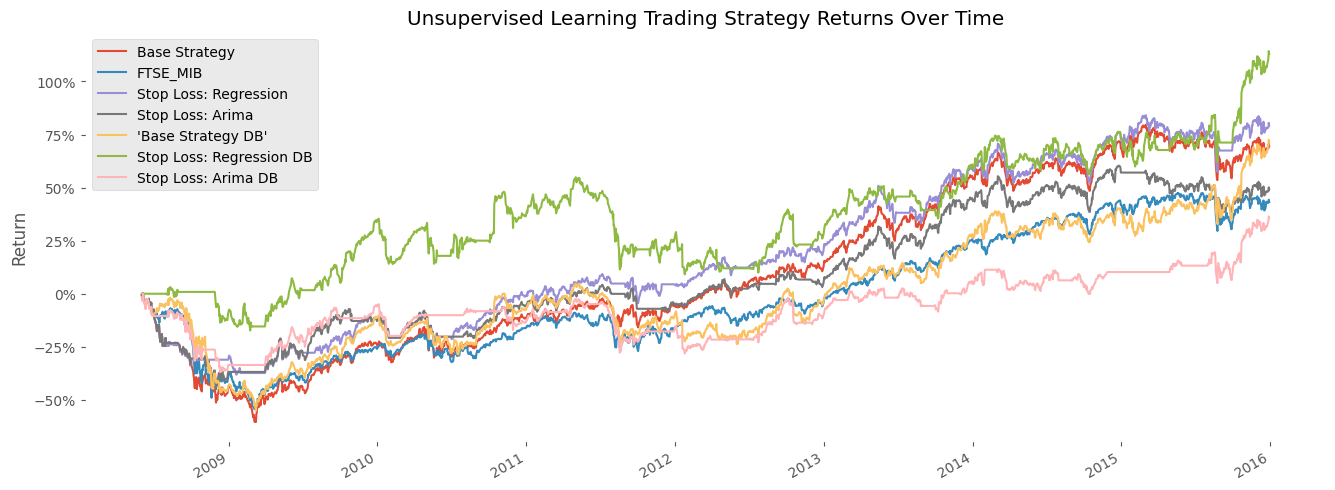

In [16]:
spy = yf.download(tickers='SPY',
                  start=start_date_train,
                  end=end_date_train)


spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SP500'}, axis=1)

p_train_results.append(spy_ret)


result_training = pd.concat(p_train_results, axis=1)


result_training.columns = ['KM base',
                         'DB base',
                         'KM reg',
                         "'DB reg'",
                         'KM Arima',
                         'DB Arima',
                         'SP500',]


In [ ]:
plot_portfolio_cumulative_return(result_training)

In [ ]:
for return_strategy, name in zip(p_train_results,result_training.columns):
    print("Results obtained using", name," : ")
    print("Volatility    : ", np.round(float(calculate_volatility(return_strategy)),5))
    print("Sharpe ratio : ", np.round(float(calculate_sharpe_ratio(return_strategy)),5))

### Validation

In [ ]:
best_rsi_data_M_km_val = data_validation.copy().dropna().groupby('date', 
                                                             group_keys=False).apply(lambda df: kmeans_best_rsi(df, 3))
chosen_stocks_km_val = list_monthly_stocks(best_rsi_data_M_km_val)

In [ ]:
best_rsi_data_M_db_val =data_validation.copy().dropna().groupby('date',
                                                                group_keys = False).apply(lambda df: dbscan_best_rsi(df))
chosen_stocks_db_val = list_monthly_stocks(best_rsi_data_M_db_val)

In [ ]:
stocks_km_val = list(np.unique([s for stocks_list in chosen_stocks_km_val.values() for s in stocks_list]))
stocks_db_val = list(np.unique([s for stocks_list in chosen_stocks_db_val.values() for s in stocks_list]))

start_date_val = data_validation.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date_val = data_validation.index.get_level_values('date').unique()[-1]

new_df_k_means_val = yf.download(tickers = stocks_km_val,
                             start = start_date_val, 
                             end = end_date_val)


new_df_db_val = yf.download(tickers = stocks_db_val,
                        start = start_date_val, 
                        end = end_date_val)

In [ ]:
p_val_results = []

In [ ]:
p_km_val = daily_portfolio_return(chosen_stocks_km_val,
                                         new_df_k_means_val, 
                                         stop_loss = False)

p_db_val = daily_portfolio_return(chosen_stocks_db_val,
                                         new_df_db_val, 
                                         stop_loss = False)

p_val_results.append(p_km_val)
p_val_results.append(p_db_val)

In [ ]:
p_km_reg_val = daily_portfolio_return(chosen_stocks_km_val,
                                      new_df_k_means_val, 
                                      off_set_days = 30, 
                                      stop_loss = True)

p_db_reg_val = daily_portfolio_return(chosen_stocks_db_val,
                                      new_df_db_val, 
                                      off_set_days = 30,
                                      stop_loss = True)

p_val_results.append(p_km_reg_val)
p_val_results.append(p_db_reg_val)

In [ ]:
p_km_ARIMA_val = daily_portfolio_return(chosen_stocks_km_val,
                                        new_df_k_means_val,
                                        off_set_days = 14,
                                        stop_loss = True,
                                        mode = 'Arima',
                                        order = (6,2,1))

p_db_ARIMA_val = daily_portfolio_return(chosen_stocks_db_val,
                                        new_df_db_val,
                                        off_set_days = 14,
                                        stop_loss = True,
                                        mode = 'Arima',
                                        order = (6,2,1))

p_val_results.append(p_km_ARIMA_val)
p_val_results.append(p_db_ARIMA_val)

In [ ]:
spy = yf.download(tickers='SPY',
                  start = start_date_validation,
                  end = end_date_validation)

mib_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SP500'}, axis=1)

p_val_results.append(mib_ret)


result_validation = pd.concat(p_val_results, axis=1)


result_validation.columns = ['KM base',
                         'DB base',
                         'KM reg',
                         "'DB reg'",
                         'KM Arima',
                         'DB Arima',
                         'SP500',]

In [ ]:
plot_portfolio_cumulative_return(result_training)

In [ ]:
for return_strategy, name in zip(p_val_results,result_validation.columns):
    print("Results obtained using", name," : ")
    print("Volatility    : ", float(calculate_volatility(return_strategy)))
    print("Sharpe ratio : ", float(calculate_sharpe_ratio(return_strategy)))